<a href="https://colab.research.google.com/github/Moshiii/pytorch_snippet/blob/master/sum_10_pytorch_one_hots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import torch
import random
from operator import eq
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def one_hot_to_num(one_hot):
  return [i for i, j in enumerate(one_hot)if j == max(one_hot)]
def npify_tsr(tsr):
  numpy.set_printoptions(suppress=True)
  return numpy.round(tsr.detach().numpy(), decimals=2)

def show_tensor(dataset,v_range=None,idx=0):
  ds=dataset.numpy()
  plt.figure(idx,figsize=(5, 5))
  print(idx)
  if v_range:
    sns.heatmap(ds, annot=True, linewidths=.5, vmin=v_range[0], vmax=v_range[1])
  else:
    sns.heatmap(ds, annot=True, linewidths=.5)
def num_to_one_hot(num):
  scatter=[0]*10
  scatter[num]=1
  return scatter


def accuracy(y_pred,y_test):
  num_pred=[one_hot_to_num(a) for a in y_pred]
  num_test=[one_hot_to_num(a) for a in y_test]
  bool_list = map(eq, num_pred, num_test)
  num_list = [1 if x==True else 0 for x in bool_list]
  acc=sum(num_list)/50
  return acc

In [0]:
class ModelLog:

  def __init__(self, model):
      self.rec_dic={0:[],1:[]}
      self.model = model
      
  def model_weight_vis(self):
      model_list = [m for m in self.model.modules()]
      w_layer_1 = model_list[1].weight.data.clone()
      model_list[1].bias.data
      w_layer_2 = model_list[3].weight.data.clone()
      self.rec_dic[0].append(w_layer_1.clone())
      self.rec_dic[1].append(w_layer_2.clone())

  def dump_all_weights(self):
    self.dump_weight(self.rec_dic[0])
    self.dump_weight(self.rec_dic[1])

  def dump_weight(self,tensor_list):
    idx=0
    for i,t in enumerate(tensor_list):
      if i>1:
        idx+=1
        show_tensor((tensor_list[i]-tensor_list[i-1])*100/tensor_list[i],idx=idx)

In [0]:
def get_sum_data(n_samples=55,shuffle=True):
  numbers=list(range(0,10))
  pair=[]
  for a in numbers:
    for b in numbers:
      if a+b<10:
        pair+=[[[num_to_one_hot(a),num_to_one_hot(b)],num_to_one_hot(a+b)]]
  random.shuffle(pair)
  pair=pair[:n_samples] 
  x_train = [x[0] for x in pair]
  y_train = [y[1] for y in pair]
  return x_train, y_train

In [0]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Feedforward, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size 
    self.fc1_1 = torch.nn.Linear(self.input_size*2, self.hidden_size)
    # self.fc1_2 = torch.nn.Linear(self.input_size, self.hidden_size)
    
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
    self.sigmoid = torch.nn.Sigmoid()
  def forward(self, x1,x2):
    self.layer_hidden =   self.fc1_1(torch.cat([x1, x2], dim=1))
    
    # input_1 = self.fc1_1(x1)
    # input_2 = self.fc1_1(x2)
    # self.layer_hidden = torch.cat((input_1.view(input_1.size(0), -1),input_2.view(input_2.size(0), -1)), dim=1)
    # self.layer_hidden = torch.cat([A, B], dim=0)
    #we need to concat two layers
    # self.layer_hidden = input_1+input_2
    # self.layer_hidden = torch.cat([input_1, input_2], dim=1)
    self.layer_hidden_relu = self.relu(self.layer_hidden)
    self.layer_output = self.fc2(self.layer_hidden_relu)
    self.layer_output_sig = self.sigmoid(self.layer_output)
    return self.layer_output_sig

In [0]:
FF_model = Feedforward(10, 3, 10)
criterion = torch.nn.BCELoss()
# optimizer = torch.optim.SGD(FF_model.parameters(), lr = 0.015)
optimizer = torch.optim.Adam(FF_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [0]:
x_train, y_train = get_sum_data(55)
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

x_test, y_test = get_sum_data(50)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

In [0]:
# model_list = [m for m in FF_model.modules()]
# model_list = [m for m in FF_model.named_children()]
# print(model_list)

In [47]:
FF_model.eval()
y_pred = FF_model(x_test[:,0],x_test[:,1])

before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training' , before_train.item())

Test loss before training 0.7395612597465515


In [48]:
FF_model.train()
epoch = 10000
record_tracker= ModelLog(FF_model)

for epoch in range(epoch):
    FF_model.train()
    optimizer.zero_grad()
    # record_tracker.model_weight_vis()
    y_pred = FF_model(x_train[:,0],x_train[:,1])# foward    
    loss = criterion(y_pred.squeeze(), y_train)
    # train_accuracy = 100 * correct / 5
    # print(train_accuracy)

    loss.backward()
    optimizer.step()

    if epoch % 2000 == 0:
      # record_tracker.model_weight_vis()
      print('Epoch {}: train loss: {}'.format(epoch, loss.item())) 
      FF_model.eval()
      y_pred = FF_model(x_test[:,0],x_test[:,1])
      before_train = criterion(y_pred.squeeze(), y_test)
      acc = accuracy(y_pred,y_test)
      print('Test loss before training================' , before_train.item())
      print(acc)
# record_tracker.dump_all_weights()

Epoch 0: train loss: 0.7400338649749756
Test loss before training================ 0.7388671636581421
0.06
Epoch 2000: train loss: 0.2507794499397278
Test loss before training================ 0.25531861186027527
0.22
Epoch 4000: train loss: 0.18809710443019867
Test loss before training================ 0.192346453666687
0.74
Epoch 6000: train loss: 0.1404256522655487
Test loss before training================ 0.14279422163963318
0.98
Epoch 8000: train loss: 0.11202332377433777
Test loss before training================ 0.1136232390999794
1.0


我之前尝试过将两个数字的one-hot向量分别输入模型结果效果并不好 后来将两个input直接concat之后输入进去结果就非常的好 这之中我又换了优化器 从SGD换成了Adam 效果非常显著 之前只用sgd的时候都是50%左右的准确率
现在竟然可以达到100 非常惊人


In [49]:
FF_model.eval()
y_pred = FF_model(x_test[:,0],x_test[:,1])
after_train = criterion(y_pred.squeeze(), y_test)
print("x_test")
# print(npify_tsr(x_test))
# print("w_1")
# print(npify_tsr(record_tracker.rec_dic[0][-1]))
# print("x_test*w_1")
# print(npify_tsr(FF_model.layer_hidden))
print("relu(x_test*w_1)")
# print(npify_tsr(FF_model.layer_hidden_relu))
# print("w_2")
# print(npify_tsr(record_tracker.rec_dic[1][-1]))
# print("relu(x_test*w_1)*w_2")
# print(npify_tsr(FF_model.layer_output))
print("sig(relu(x_test*w_1)*w_2)")
# print(npify_tsr(FF_model.layer_output_sig))


x_test
relu(x_test*w_1)
sig(relu(x_test*w_1)*w_2)


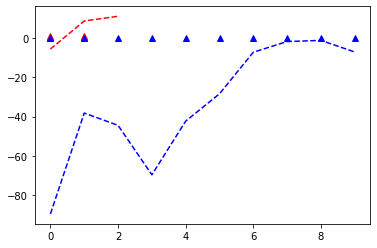

In [50]:
import matplotlib.pyplot as plt
plt.plot(x_test[1],"r^")
plt.plot(npify_tsr(FF_model.layer_hidden)[1],'r--')
# plt.plot(npify_tsr(FF_model.layer_hidden_relu)[0],'r^')

plt.plot(npify_tsr(FF_model.layer_output)[1],'b--')
plt.plot(npify_tsr(FF_model.layer_output_sig)[1],'b^')

plt.show()

红线波动近似随机。 这里面我用了3个node来学习两个数字十以内的加法。结果发现跟100的比较起来没有本质区别 说明有的时候多余的权重只会让信息更加稀疏降低效率。 这个发现也印证了模型压缩的可行性。这算是这次实验的发现。

In [0]:
record_tracker.dump_all_weights()

In [0]:
tensor_list = record_tracker.rec_dic[1]
idx=0
for i,t in enumerate(tensor_list):
  idx+=1
  if i>1:
    # show_tensor((tensor_list[i]-tensor_list[i-1])/tensor_list[i],idx=idx)
    show_tensor(tensor_list[i],idx=idx)
    # plt.plot_surface(range(10), range(10), tensor_list[i])

In [0]:

tensor_list = record_tracker.rec_dic[0]
show_tensor(tensor_list[-1],idx=0)
tensor_list = record_tracker.rec_dic[1]
show_tensor(tensor_list[-1],idx=1)


In [0]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0,2,1)
Y = np.arange(0,3,1)
X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, tensor_list[i].numpy(), cmap=cm.coolwarm, linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_zlim(-10, 10)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()
# ax.view_init(30, 20)
plt.show()
# plt.pause(.001)